In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree

import SweetSpotPrediction as ssp

# 04b GausianNb
*Note: Run 01 to build the .csv files needed*

In [2]:
df = pd.read_csv('ClassificationData.csv')

df.head()

,Unnamed: 0,XPos,YPos,Thickness,AvgNTG,AvgPerm,AvgPoro,NetPerm,SweetSpot,WellPresent,PermTimesPoro
0,0,452000.0,6780600.0,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,1,452000.0,6780650.0,NaN,NaN,NaN,NaN,NaN,0,0,NaN
2,2,452000.0,6780700.0,NaN,NaN,NaN,NaN,NaN,0,0,NaN
3,3,452000.0,6780750.0,NaN,NaN,NaN,NaN,NaN,0,0,NaN
4,4,452000.0,6780800.0,NaN,NaN,NaN,NaN,NaN,0,0,NaN


In [3]:
features = [
    #'XPos', # propbably dont want these as features
    #'YPos', # propbably dont want these as features
    'Thickness',
    'AvgNTG',
    'AvgPerm',
    'AvgPoro', # removing this increases Gauss with a very small fraction (0.260 to 0.266)
    'NetPerm',
    #'PermTimesPoro',
]

label_clf = 'SweetSpot' # 'WellPresent' 
label_reg = 'WellProbability'
lable_swt = 'SweetSpot'


In [4]:
df.dropna(inplace=True)

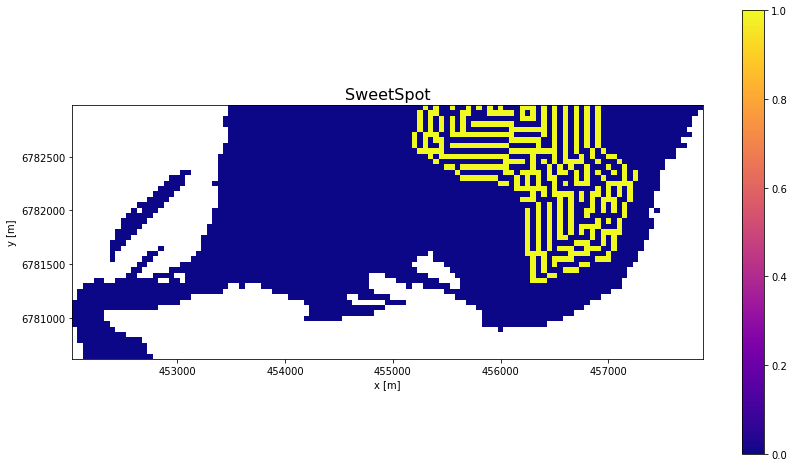

In [5]:
#X_train, X_, y_train, y_ = train_test_split(df[features], df[label_clf], test_size=0.33, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.50, random_state=42)

horizontalBoundary = 6783000

df1 = df.loc[df['YPos'] < horizontalBoundary]
df2 = df.loc[df['YPos'] >= horizontalBoundary]

ssp.plot_map(df1, 'SweetSpot', dtype='cat')

In [6]:
X_train = df1[features]
X_val = df2[features]

y_train =df1['SweetSpot'].values
y_val =df2['SweetSpot'].values

#df.shape
#df1.shape
#X_train = df[df['YPos'] > 6784700, features]
#X_val = df[df['YPos'] <= 6784700, features]

#y_train = df[df['YPos'] > 6784700, label_clf]
#y_val = df[df['YPos'] <= 6784700, label_clf]


# Normalization and other preprocessing

In [7]:
preprocessing = StandardScaler()
X_train = preprocessing.fit_transform(X_train)
#X_test = preprocessing.transform(X_test)
X_val = preprocessing.transform(X_val)
X_train[:5]

array([[-1.63259405, -0.94565985,  1.93817252, -0.85737717],
       [-1.5789604 , -0.81336229,  2.82596954, -0.66145285],
       [-1.5734108 , -0.08523032,  3.04269405, -0.58941378],
       [-1.585708  ,  0.87690542,  2.42958103, -0.66971622],
       [-1.60318195,  1.30003626,  0.73766832, -0.87655848]])

In [8]:
#from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
    
classifiers = [
    #AdaBoostClassifier(n_estimators=200),
    #DecisionTreeClassifier(class_weight='balanced'),
    #GradientBoostingClassifier(),
    GaussianNB(),
    #KNeighborsClassifier(3),
    #NuSVC(probability=True),
    #LinearDiscriminantAnalysis(),
    #MLPClassifier(hidden_layer_sizes=(200,4),max_iter=1000),
    #QuadraticDiscriminantAnalysis(),
    #RandomForestClassifier(class_weight='balanced',n_estimators=200),
    #SVC(kernel="rbf", C=0.25, probability=True,class_weight='balanced'),

    ]

In [9]:
for index, clf in enumerate(classifiers):
    print(f"Model {index}: {clf}")
    clf.fit(X_train, y_train)
    y_pred_val = clf.predict(X_val)
    ssp.ReportMetrics(clf, X_train, X_val, y_train, y_val, y_pred_val)
    print(f"-------------------------------------------------------------------")

Model 0: GaussianNB(priors=None, var_smoothing=1e-09)
Precision: 0.172
Recall: 0.592
F1: 0.266
-------------------------------------------------------------------


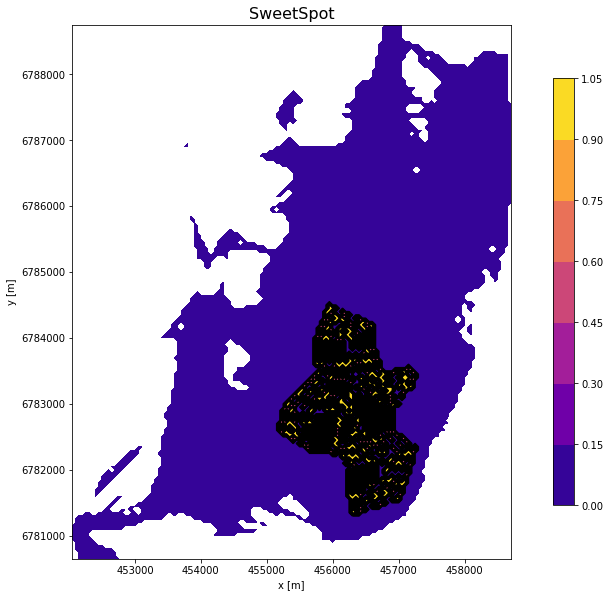

In [10]:
ssp.plot_map(df, 'SweetSpot')

In [11]:
bestModel = classifiers[0]
#ssp.plot_feature_importances(bestModel,features)

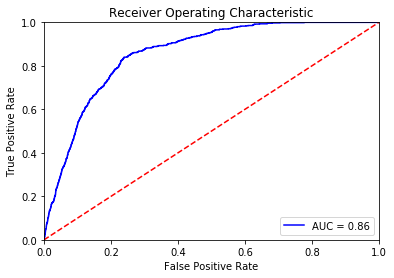

In [12]:
from sklearn.metrics import roc_curve, auc
df['prediction_prob'] = bestModel.predict_proba(preprocessing.transform(df[features]))[:,1]

fpr, tpr, threshold = roc_curve(df[label_clf], df['prediction_prob'] )

roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

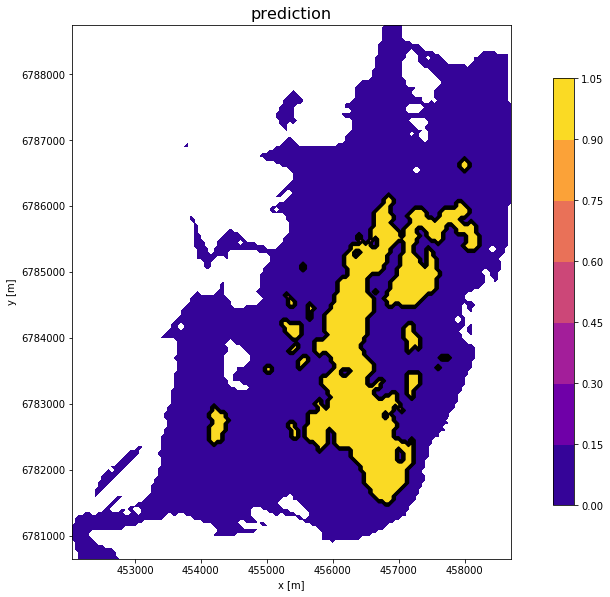

In [13]:



df['prediction'] = bestModel.predict(preprocessing.transform(df[features]))
ssp.plot_map(df, 'prediction')


In [14]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn import metrics

weights_train = compute_sample_weight(class_weight='balanced', y=y_train)
weights_test = compute_sample_weight(class_weight='balanced', y=y_val)

print("Weighted accuracy on training set: {:.3f}".format(bestModel.score(X_train, y_train, sample_weight=weights_train)))
print("Weighted accuracy on test set: {:.3f}".format(bestModel.score(X_val, y_val,weights_test)))

Weighted accuracy on training set: 0.772
Weighted accuracy on test set: 0.727


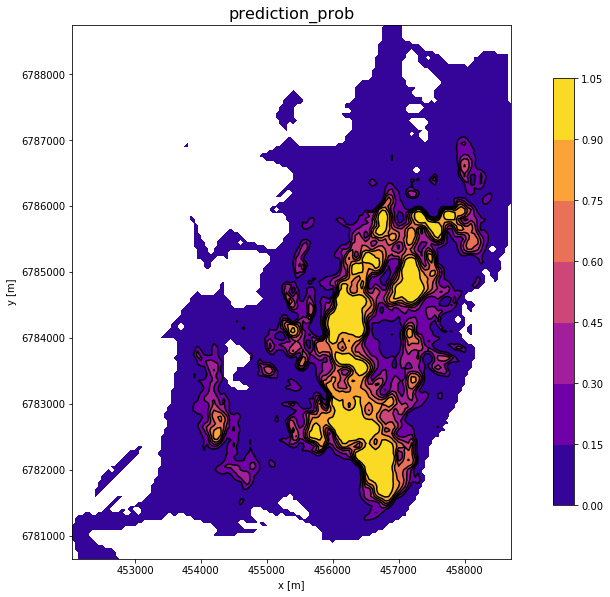

In [15]:

ssp.plot_map(df, 'prediction_prob')

# <a href="02 Base Model.ipynb">Previous</a> <a href="04 Classification model.ipynb">Next</a> Notebook